In [17]:
# This notebook addresses class imbalance in the image classification project using:
# - Class weighting
# - Basic data augmentation
# - Optional GPU acceleration on Mac via `MAC_MODE`
# - Visualization of accuracy and loss


In [18]:
import os
import time

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from datetime import datetime

In [19]:
# Toggle for local Mac GPU support
MAC_MODE = True  # Set to False for Windows/Linux

if MAC_MODE:
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
    print("Mac mode enabled (Metal acceleration will be used if available).")
    print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
else:
    physical_devices = tf.config.list_physical_devices('GPU')
    if physical_devices:
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
        print(f"Using GPU: {physical_devices[0].name}")
    else:
        print("No GPU found. Running on CPU.")


Mac mode enabled (Metal acceleration will be used if available).
Num GPUs Available: 1


In [20]:

def get_data(datasplit="balanced", image_size=(224, 224), batch_size=32, augment = False):

    assert datasplit in ["full", "balanced"], "datasplit must be 'full' or 'balanced'"

    if datasplit == "balanced":
        train_dir = "data_split_balanced/train"
    else:
        train_dir = "data_split/train"
    
    test_dir = "data_split/test"

    if datasplit == "full" and augment:
        train_datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=30,
            zoom_range=0.2,
            brightness_range=(0.8, 1.2),
            fill_mode='nearest'
        )
    else:
        train_datagen = ImageDataGenerator(rescale=1./255)

    train_gen = train_datagen.flow_from_directory(
        train_dir,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True
    )

    test_datagen = ImageDataGenerator(rescale=1./255)
    test_gen = test_datagen.flow_from_directory(
        test_dir,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )


    class_indices = train_gen.class_indices
    inv_class_indices = {v: k for k, v in class_indices.items()}
    class_counts = dict.fromkeys(inv_class_indices.values(), 0)
    for i in train_gen.classes:
        label = inv_class_indices[i]
        class_counts[label] += 1

    plt.figure(figsize=(6, 4))
    plt.bar(class_counts.keys(), class_counts.values(), color='teal')
    plt.title(f"Class Distribution ({datasplit} set)")
    plt.xlabel("Class")
    plt.ylabel("Number of Samples")
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

    return train_gen, test_gen


In [21]:
def get_class_weights(train_gen):    
    counts = train_gen.classes
    weights = compute_class_weight(class_weight="balanced", classes=np.unique(counts), y=counts)
    class_weights = dict(zip(np.unique(counts), weights))
    print("Computed class weights:", class_weights)

    return class_weights


In [22]:
def build_model(image_size=(224, 224), num_classes=3):
    base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(*image_size, 3))
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dropout(0.3),
        Dense(num_classes, activation="softmax")
    ])
    return model, base_model


In [23]:
def run_training(train_gen, test_gen, class_weights, model, base_model, stage=3, stage_epochs=[3, 5, 3], training_layers=50):
    print(f"\n Starting {stage}-stage training")
    stage_1_epochs, stage_2_epochs, stage_3_epochs = stage_epochs

    def plot_history(history, label):
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
        loss = history.history['loss']
        val_loss = history.history['val_loss']
        epochs = range(1, len(acc) + 1)

        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(epochs, acc, 'bo-', label='Train')
        plt.plot(epochs, val_acc, 'ro-', label='Val')
        plt.title(f'{label} - Accuracy')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(epochs, loss, 'bo-', label='Train')
        plt.plot(epochs, val_loss, 'ro-', label='Val')
        plt.title(f'{label} - Loss')
        plt.legend()
        plt.show()

    if stage >= 1:
        print("Stage 1: training top layers (frozen base)")
        base_model.trainable = False
        model.compile(optimizer=Adam(1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
        hist = model.fit(train_gen, validation_data=test_gen, epochs=stage_1_epochs, class_weight=class_weights)
        plot_history(hist, "Stage 1")

    if stage >= 2:
        print(f"Stage 2: fine-tuning last {training_layers} layers")
        base_model.trainable = True
        for layer in base_model.layers[:-training_layers]:
            layer.trainable = False
        model.compile(optimizer=Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
        hist = model.fit(train_gen, validation_data=test_gen, epochs=stage_2_epochs, class_weight=class_weights)
        plot_history(hist, "Stage 2")

    if stage >= 3:
        print("Stage 3: full model fine-tuning")
        for layer in base_model.layers:
            layer.trainable = True
        model.compile(optimizer=Adam(1e-7), loss='categorical_crossentropy', metrics=['accuracy'])
        hist = model.fit(train_gen, validation_data=test_gen, epochs=stage_3_epochs, class_weight=class_weights)
        plot_history(hist, "Stage 3")

    # Confusion Matrix
    print("Final Confusion Matrix:")
    y_true = test_gen.classes
    y_pred = np.argmax(model.predict(test_gen), axis=1)
    labels = list(test_gen.class_indices.keys())

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap='Blues')
    plt.xticks(rotation=20)
    plt.grid(False)
    plt.show()

    return model


## Transfer Learning and Timing

Found 4007 images belonging to 3 classes.
Found 1861 images belonging to 3 classes.


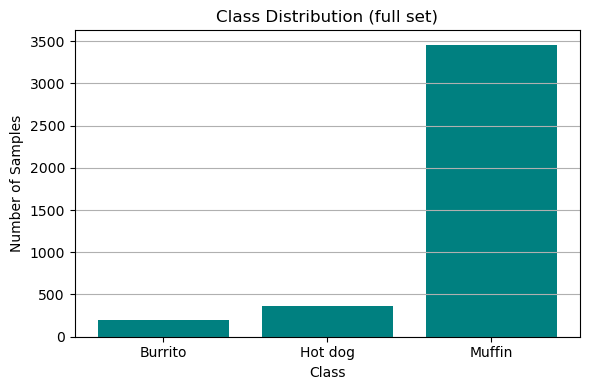

Computed class weights: {0: 6.742753623188406, 1: 3.714570858283433, 2: 0.38722430295464005}

 Starting 2-stage training
Stage 1: training top layers (frozen base)
Epoch 1/3


/Users/daniel/miniconda3/envs/data_engineering/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


126/126 ━━━━━━━━━━━━━━━━━━━━ 25s 146ms/step - accuracy: 0.3000 - loss: 1.2519 - val_accuracy: 0.0553 - val_loss: 1.1063
Epoch 2/3
126/126 ━━━━━━━━━━━━━━━━━━━━ 16s 129ms/step - accuracy: 0.4452 - loss: 1.0635 - val_accuracy: 0.6024 - val_loss: 0.9707
Epoch 3/3
126/126 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - accuracy: 0.3351 - loss: 1.1533 - val_accuracy: 0.5255 - val_loss: 0.9852


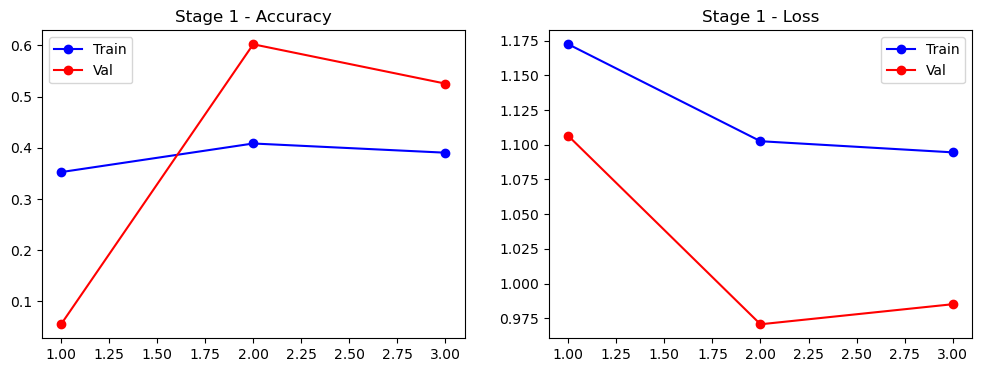

Stage 2: fine-tuning last 30 layers
Epoch 1/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 42s 236ms/step - accuracy: 0.7884 - loss: 6.4303 - val_accuracy: 0.8608 - val_loss: 0.5537
Epoch 2/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 27s 214ms/step - accuracy: 0.5847 - loss: 0.9398 - val_accuracy: 0.8689 - val_loss: 0.4334
Epoch 3/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 27s 213ms/step - accuracy: 0.7098 - loss: 0.7411 - val_accuracy: 0.7700 - val_loss: 0.6061
Epoch 4/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 27s 218ms/step - accuracy: 0.7502 - loss: 0.6654 - val_accuracy: 0.4315 - val_loss: 1.0326
Epoch 5/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 27s 216ms/step - accuracy: 0.7552 - loss: 0.5923 - val_accuracy: 0.5384 - val_loss: 0.9077
Epoch 6/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 27s 211ms/step - accuracy: 0.7908 - loss: 0.5410 - val_accuracy: 0.7496 - val_loss: 0.5595
Epoch 7/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 26s 210ms/step - accuracy: 0.7779 - loss: 0.4736 - val_accuracy: 0.8587 - val_loss: 0.3734
Epoch 8/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 26s 210

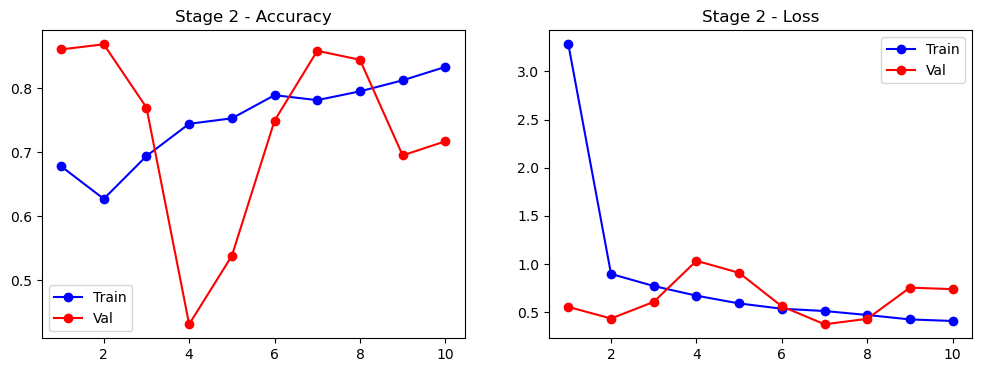

Final Confusion Matrix:
59/59 ━━━━━━━━━━━━━━━━━━━━ 9s 121ms/step


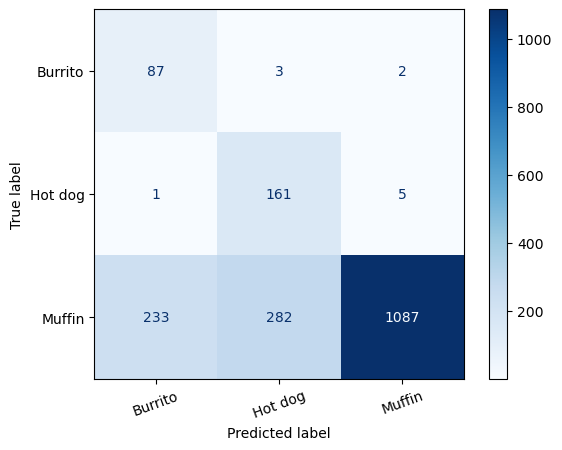

Training time: 351.71 seconds


In [24]:
train_gen, test_gen = get_data(datasplit="full", augment=False)
class_weights = get_class_weights(test_gen)

model, base_model = build_model()
start = time.time()
model = run_training(train_gen, test_gen, class_weights, model, base_model, stage=2, stage_epochs=[3, 10, 1], training_layers=50)
print("Training time:", round(time.time() - start, 2), "seconds")





In [28]:
#model.save("resnet50_final.keras")


In [25]:
# Get the base model
resnet_base = model.get_layer("resnet50")
print(f"ResNet50 has {len(resnet_base.layers)} layers.")

# Check for trainable Layers
conv_layers = [layer for layer in resnet_base.layers if "conv" in layer.name]
print(f"Trainable conv layers: {len(conv_layers)}")


ResNet50 has 175 layers.
Trainable conv layers: 172


## Inference Time and Used Hardware

In [26]:
print("Device:", tf.config.list_physical_devices())


start = time.time()
model.predict(test_gen, verbose=1)
print("Inference time on test set:", round(time.time() - start, 2), "seconds")

Device: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step
Inference time on test set: 4.91 seconds


## Model Parameters

In [27]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │         6,147 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,507,211 (219.37 MB)

 Trainable params: 16,956,675 (64.68 MB)

 Non-trainable params: 6,637,184 (25.32 MB)

 Optimizer params: 33,913,352 (129.37 MB)

## Categories most confused
The model most frequently confused all classes with "muffin", as clearly shown in the confusion matrix. This is due to severe data imbalance.

## Discussion
We used staged training with ResNet50 on both the full and a balanced subset of the dataset, with and without augmentation. Despite these variations, the model remained biased toward the dominant class. This is likely due to class imbalance, poor image quality, and minimal visual distinction between categories. Additionally, ImageNet pretraining limited transferability due to its unrelated domain. Better results may require higher-quality data, improved balance, or domain-specific pretraining.